In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
import pandas as pd
from glob import glob

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
DATA_PATH = "/Users/nataliesgarcia/Desktop/dtsc4301/data/AirData/*.csv"
OUTPUT_PATH = "/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights.csv"
DELAY_THRESHOLD = 15

# --------------------------------------------------
# CLEANING FUNCTION
# --------------------------------------------------
def clean_monthly_file(filepath):
    df = pd.read_csv(filepath, low_memory=False)

    # Create delay label (DOT standard)
    df["DELAYED"] = df["ARR_DELAY"] >= DELAY_THRESHOLD

    # Create disruption flag
    df["DISRUPTED"] = (df["DELAYED"]) | (df["CANCELLED"] == 1)

    # Keep only delayed or cancelled flights
    df = df[df["DISRUPTED"]]

    # Keep relevant columns (including DELAYED)
    df = df[
        [
            "FL_DATE", "MONTH", "DAY_OF_WEEK",
            "OP_CARRIER_FL_NUM", "ORIGIN", "DEST",
            "DEP_DELAY", "ARR_DELAY",
            "CANCELLED", "CANCELLATION_CODE",
            "WEATHER_DELAY", "NAS_DELAY",
            "CARRIER_DELAY", "SECURITY_DELAY",
            "LATE_AIRCRAFT_DELAY",
            "DELAYED"
        ]
    ]

    return df

# --------------------------------------------------
# LOAD, CLEAN, AND COMBINE ALL MONTHS
# --------------------------------------------------
files = glob(DATA_PATH)
print("Monthly files found:", len(files))

if len(files) == 0:
    raise FileNotFoundError("No CSV files found. Check path.")

monthly_dfs = []

for f in files:
    df_clean = clean_monthly_file(f)
    if not df_clean.empty:
        monthly_dfs.append(df_clean)

if len(monthly_dfs) == 0:
    raise ValueError("No delayed or cancelled flights found.")

# Combine all months into one DataFrame
full_df = pd.concat(monthly_dfs, ignore_index=True)

print("Total delayed or cancelled flights:", full_df.shape[0])

# --------------------------------------------------
# SAVE MASTER CSV
# --------------------------------------------------
full_df.to_csv(OUTPUT_PATH, index=False)

print("Saved cleaned dataset to:")
print(OUTPUT_PATH)


Monthly files found: 12
Total delayed or cancelled flights: 1531038
Saved cleaned dataset to:
/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights.csv


Total disrupted flights: 1531038
                FL_DATE  MONTH  DAY_OF_WEEK  OP_CARRIER_FL_NUM ORIGIN DEST  \
0  2/1/2024 12:00:00 AM      2            4             4865.0    MEM  LGA   
1  2/1/2024 12:00:00 AM      2            4             4906.0    LGA  PIT   
2  2/1/2024 12:00:00 AM      2            4             4912.0    DHN  ATL   
3  2/1/2024 12:00:00 AM      2            4             4916.0    LGA  DSM   
4  2/1/2024 12:00:00 AM      2            4             4944.0    ATL  DHN   

   DEP_DELAY  ARR_DELAY  CANCELLED CANCELLATION_CODE  WEATHER_DELAY  \
0       -5.0       28.0        0.0               NaN            0.0   
1      121.0      112.0        0.0               NaN            0.0   
2      167.0      154.0        0.0               NaN            0.0   
3       30.0       18.0        0.0               NaN            0.0   
4        0.0       29.0        0.0               NaN            0.0   

   NAS_DELAY  CARRIER_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  DELAY

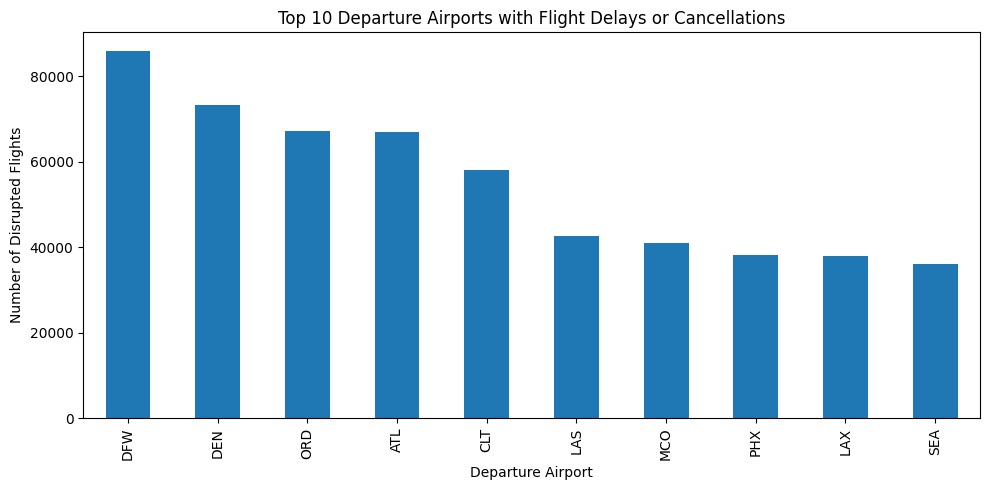


Disruptions by Month:
MONTH
1     146799
2      85038
3     127152
4     113989
6     315642
7     200237
8     154526
10    173254
11     86529
12    127872
dtype: int64


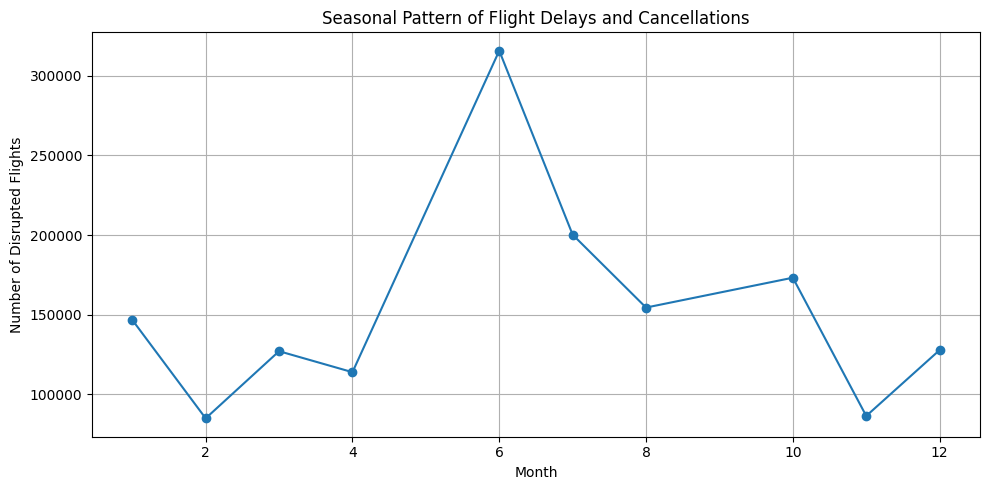


Disruptions by Day of Week:
DAY_OF_WEEK
1    225387
2    184475
3    189857
4    231279
5    248443
6    201318
7    250279
dtype: int64


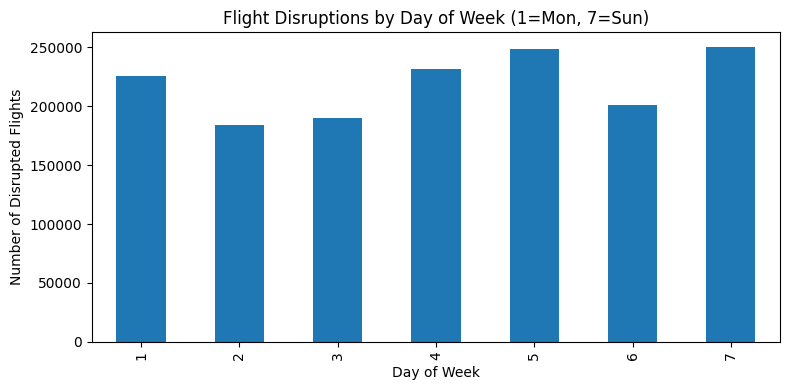


Hub vs Non-Hub Disruptions:
HUB_STATUS
Non-Hub    983301
Hub        547737
Name: count, dtype: int64


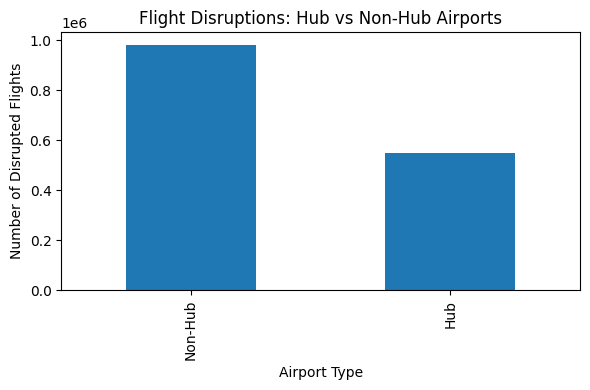


Average Delay Minutes by Hub Status:
            DEP_DELAY  ARR_DELAY
HUB_STATUS                      
Hub         63.630649  66.622642
Non-Hub     69.925193  73.897491


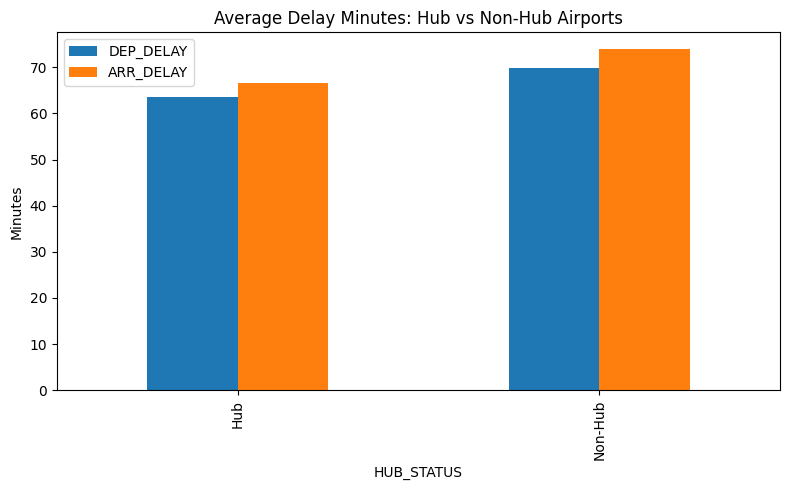

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# LOAD MASTER CLEANED DATA
# --------------------------------------------------
DATA_PATH = "/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)

print("Total disrupted flights:", df.shape[0])
print(df.head())

# --------------------------------------------------
# BASIC EDA
# --------------------------------------------------
print("\nDelayed vs Cancelled Counts:")
print(df["DELAYED"].value_counts())

# Delay causes
delay_causes = [
    "WEATHER_DELAY",
    "NAS_DELAY",
    "CARRIER_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY"
]

print("\nAverage Delay Minutes by Cause:")
print(df[delay_causes].mean().sort_values(ascending=False))

# --------------------------------------------------
# MOST COMMON DEPARTURE AIRPORTS WITH DISRUPTIONS
# --------------------------------------------------
top_airports = (
    df.groupby("ORIGIN")
      .size()
      .sort_values(ascending=False)
      .head(10)
)

print("\nTop 10 Departure Airports with Delays/Cancellations:")
print(top_airports)

top_airports.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Departure Airports with Flight Delays or Cancellations")
plt.xlabel("Departure Airport")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# SEASONAL ANALYSIS (MONTHLY)
# --------------------------------------------------
monthly_disruptions = (
    df.groupby("MONTH")
      .size()
      .sort_index()
)

print("\nDisruptions by Month:")
print(monthly_disruptions)

monthly_disruptions.plot(marker="o", figsize=(10,5))
plt.title("Seasonal Pattern of Flight Delays and Cancellations")
plt.xlabel("Month")
plt.ylabel("Number of Disrupted Flights")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# SEASONAL ANALYSIS (DAY OF WEEK)
# --------------------------------------------------
dow_disruptions = (
    df.groupby("DAY_OF_WEEK")
      .size()
      .sort_index()
)

print("\nDisruptions by Day of Week:")
print(dow_disruptions)

dow_disruptions.plot(kind="bar", figsize=(8,4))
plt.title("Flight Disruptions by Day of Week (1=Mon, 7=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# HUB VS NON-HUB ANALYSIS
# --------------------------------------------------
# Define hubs as top 10 busiest departure airports
hub_airports = top_airports.index.tolist()

df["HUB_STATUS"] = df["ORIGIN"].apply(
    lambda x: "Hub" if x in hub_airports else "Non-Hub"
)

hub_counts = df["HUB_STATUS"].value_counts()

print("\nHub vs Non-Hub Disruptions:")
print(hub_counts)

hub_counts.plot(kind="bar", figsize=(6,4))
plt.title("Flight Disruptions: Hub vs Non-Hub Airports")
plt.xlabel("Airport Type")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# HUB VS NON-HUB DELAY SEVERITY
# --------------------------------------------------
hub_delay_stats = (
    df.groupby("HUB_STATUS")[["DEP_DELAY", "ARR_DELAY"]]
      .mean()
)

print("\nAverage Delay Minutes by Hub Status:")
print(hub_delay_stats)

hub_delay_stats.plot(kind="bar", figsize=(8,5))
plt.title("Average Delay Minutes: Hub vs Non-Hub Airports")
plt.ylabel("Minutes")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Load full cleaned dataset
df = pd.read_csv("/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights.csv")

print("Full dataset size:", df.shape)

# Create reproducible 10k sample
df_sample = df.sample(n=10000, random_state=42)

# Save sample version
df_sample.to_csv("/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights_sample.csv", index=False)

print("Sample dataset saved.")
print("Sample size:", df_sample.shape)


Full dataset size: (1531038, 16)
Sample dataset saved.
Sample size: (10000, 16)


Sample dataset size: (10000, 16)

Delayed vs Cancelled Counts:
DELAYED
True     9325
False     675
Name: count, dtype: int64

Average Delay Minutes by Cause:
LATE_AIRCRAFT_DELAY    28.082145
CARRIER_DELAY          24.538338
NAS_DELAY              13.096086
WEATHER_DELAY           4.057265
SECURITY_DELAY          0.125469
dtype: float64

Top 10 Departure Airports with Disruptions:
ORIGIN
DFW    535
ATL    468
DEN    457
ORD    453
CLT    362
LAS    323
LAX    260
SEA    247
MCO    233
EWR    221
dtype: int64


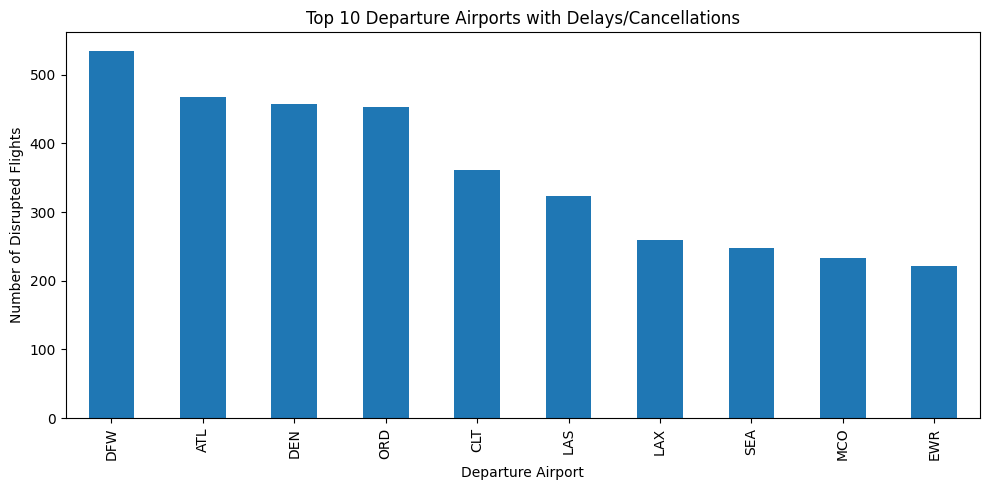

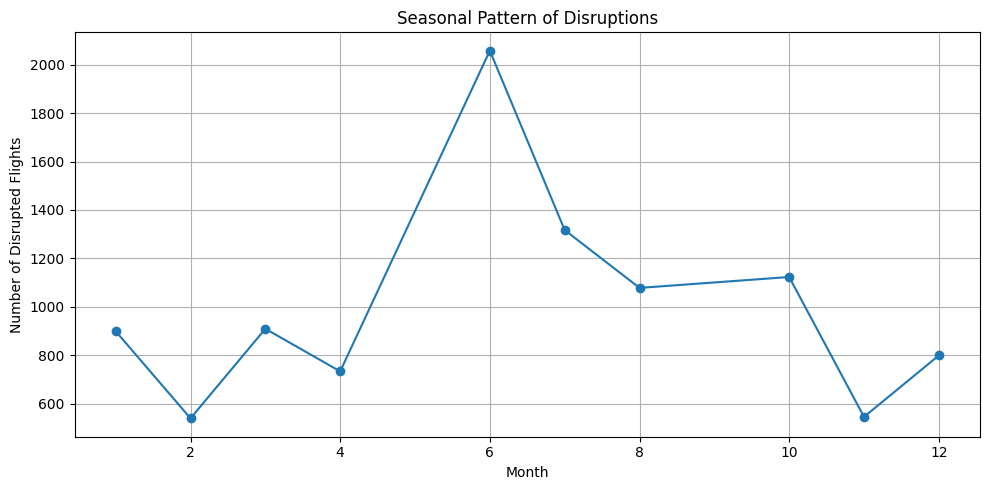

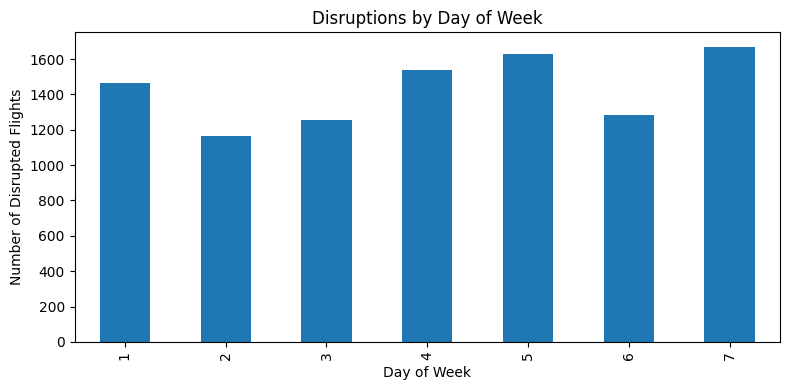

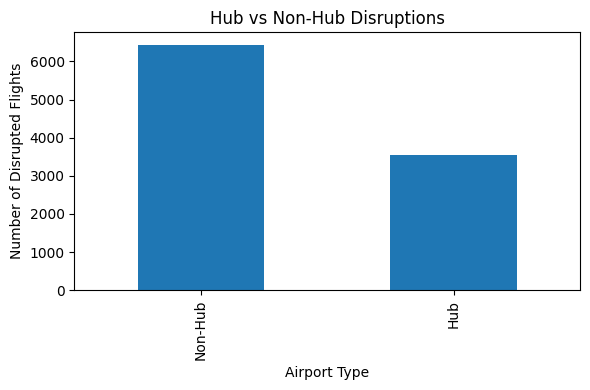


Average Delay Minutes by Hub Status:
            DEP_DELAY  ARR_DELAY
HUB_STATUS                      
Hub         64.852138  67.861053
Non-Hub     67.673960  71.047954


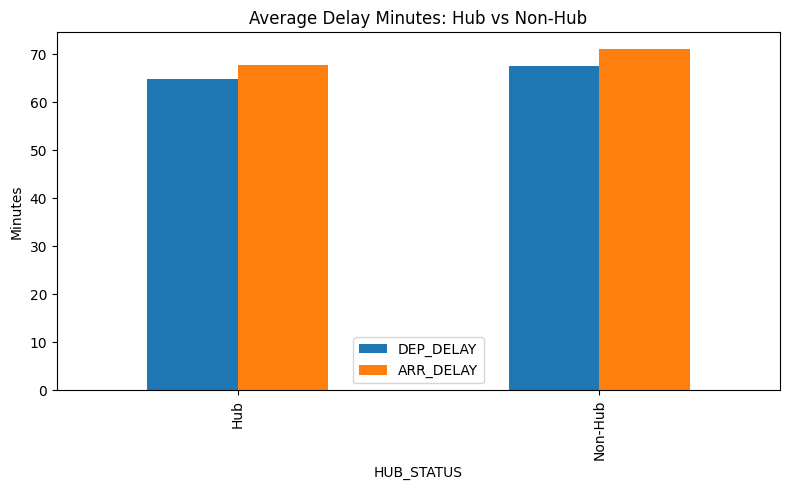

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# LOAD SAMPLE DATA
# --------------------------------------------------
df = pd.read_csv("/Users/nataliesgarcia/Desktop/dtsc4301/data/Delayed_Cancelled_Flights_sample.csv")

print("Sample dataset size:", df.shape)

# --------------------------------------------------
# BASIC EDA
# --------------------------------------------------
print("\nDelayed vs Cancelled Counts:")
print(df["DELAYED"].value_counts())

# Delay causes
delay_causes = [
    "WEATHER_DELAY",
    "NAS_DELAY",
    "CARRIER_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY"
]

print("\nAverage Delay Minutes by Cause:")
print(df[delay_causes].mean().sort_values(ascending=False))

# --------------------------------------------------
# TOP DEPARTURE AIRPORTS
# --------------------------------------------------
top_airports = (
    df.groupby("ORIGIN")
      .size()
      .sort_values(ascending=False)
      .head(10)
)

print("\nTop 10 Departure Airports with Disruptions:")
print(top_airports)

top_airports.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Departure Airports with Delays/Cancellations")
plt.xlabel("Departure Airport")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# SEASONAL ANALYSIS (MONTH)
# --------------------------------------------------
monthly_disruptions = df.groupby("MONTH").size().sort_index()

monthly_disruptions.plot(marker="o", figsize=(10,5))
plt.title("Seasonal Pattern of Disruptions")
plt.xlabel("Month")
plt.ylabel("Number of Disrupted Flights")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# DAY OF WEEK ANALYSIS
# --------------------------------------------------
dow_disruptions = df.groupby("DAY_OF_WEEK").size().sort_index()

dow_disruptions.plot(kind="bar", figsize=(8,4))
plt.title("Disruptions by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# HUB VS NON-HUB
# --------------------------------------------------
hub_airports = top_airports.index.tolist()

df["HUB_STATUS"] = df["ORIGIN"].apply(
    lambda x: "Hub" if x in hub_airports else "Non-Hub"
)

hub_counts = df["HUB_STATUS"].value_counts()

hub_counts.plot(kind="bar", figsize=(6,4))
plt.title("Hub vs Non-Hub Disruptions")
plt.xlabel("Airport Type")
plt.ylabel("Number of Disrupted Flights")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# HUB VS NON-HUB AVERAGE DELAYS
# --------------------------------------------------
hub_delay_stats = (
    df.groupby("HUB_STATUS")[["DEP_DELAY", "ARR_DELAY"]]
      .mean()
)

print("\nAverage Delay Minutes by Hub Status:")
print(hub_delay_stats)

hub_delay_stats.plot(kind="bar", figsize=(8,5))
plt.title("Average Delay Minutes: Hub vs Non-Hub")
plt.ylabel("Minutes")
plt.tight_layout()
plt.show()
